# Goal: investigate error rate impact and detector performance for rays that only partly affect a patch

These results will be used to tune the detector sensitivity such that we can be
confident that we will always detect a ray that has negative effects. We will
then need to investigate the false positive rate of this detector.

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import mpmath
import dill as pickle
import sinter
import qc_utils.stats
import qc_utils.matplotlib_setup as mpl_setup

from ray_delay.noise_model_patch import NoiseModelPatch
from ray_delay.noise_model import RayModelType
from ray_delay.ray_detector import RayDetectorSpec, RayImpactSimulator
from stim_surface_code.memory import MemoryPatch
from stim_surface_code.patch import Qubit, DataQubit, MeasureQubit

In [2]:
mpl_setup.setup_default()

In [3]:
dx = 9
dz = 9
dm = 9

patch = NoiseModelPatch(MemoryPatch(dx, dz, dm))
patch.noise_model.save_error_vals = True
patch.noise_params.cosmic_ray_params.model = RayModelType.DIRECT

mpmath.mp.dps = 50

In [4]:
sim = RayImpactSimulator(patch, spatial_window_size=1, only_full_windows=True)

In [5]:
spec = sim.generate_detector_spec(window_fpr=mpmath.mpf(1e-11), cycles_per_distillation=18, decay_nsteps=1, save_detector_spec=True)

In [6]:
spec.baseline_signal_rate

1.0102063706563116e-12

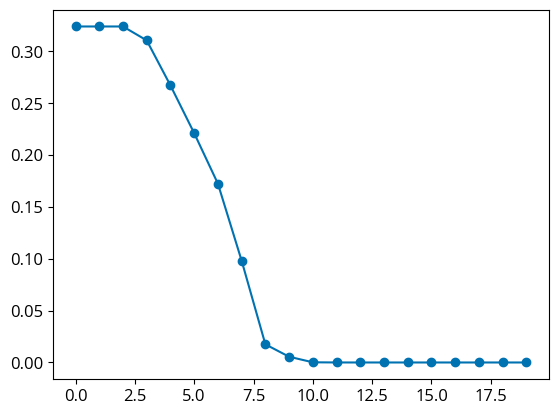

In [7]:
plt.plot(spec.first_distillation_chance(np.linspace(0, 10, 20)))

In [ ]:
baseline_result = sinter.collect(tasks=[patch.patch.get_sinter_task()], num_workers=6, decoders='pymatching', max_shots=10**7)[0]

In [9]:
dx = 9
dz = 9
dm = 9
patch = NoiseModelPatch(MemoryPatch(dx, dz, dm))
patch.noise_model.save_error_vals = True

distances = range(20)
dst_to_draw = 10
signal_chances = np.zeros(len(distances), dtype=mpmath.mpf)
sinter_tasks = []
lers = np.zeros(len(distances))
for i,d in enumerate(distances):
    ray_coords = (len(patch.patch.device)//2, len(patch.patch.device[0])//2 + d)
    qubit_distances_from_center = np.linalg.norm(patch.patch.all_qubit_coords - np.array(ray_coords), axis=1)

    # see whether we detect a ray
    no_signal_chances = np.zeros(len(patch.patch.all_qubits), dtype=mpmath.mpf)
    for j,q in enumerate(patch.patch.all_qubits):
        no_signal_chances[j] = 1-spec.first_distillation_chance([qubit_distances_from_center[j]])
    signal_chances[i] = 1-np.prod(no_signal_chances)

    # investigate logical error rate due to ray
    patch.reset()
    patch.force_cosmic_ray_by_coords(ray_coords)
    patch.step(0)
    sinter_tasks.append(patch.patch.get_sinter_task({'json_metadata':{'distance':d}}))

    if d == dst_to_draw:
        plot_vals = np.full(len(patch.patch.all_qubits), np.nan)
        for i,val in patch.noise_model.get_error_val_dict()['T1'].items():
            plot_vals[i] = val
        ax, cbar = patch.patch.plot_qubit_vals(plot_vals*1e6, plot_text='none')
        ylims = ax.get_ylim()
        ax.add_patch(plt.Circle((ray_coords[1], ray_coords[0]), 6, color='r', linewidth=2, zorder=10, fill=False))
        ax.set_ylim(ylims)
        plt.savefig('../figures/offset_ray.svg', bbox_inches='tight')
        plt.close()

    # ler, shots = patch.patch.count_logical_errors()
    # lers[i] = ler

In [10]:
sinter_results = sinter.collect(tasks=sinter_tasks, num_workers=6, decoders='pymatching', max_shots=10**7)

In [11]:
sorted_sinter_results = sorted(sinter_results, key=lambda x: x.json_metadata['distance'])

baseline_fit = sinter.fit_binomial(num_shots=baseline_result.shots, num_hits=baseline_result.errors, max_likelihood_factor=1000)
result_fits = [sinter.fit_binomial(num_shots=r.shots, num_hits=r.errors, max_likelihood_factor=1000) for r in sorted_sinter_results]

In [12]:
baseline_fit1 = qc_utils.stats.fit_binomial(num_shots=baseline_result.shots, num_hits=baseline_result.errors, max_likelihood_factor=1000)
result_fits1 = [qc_utils.stats.fit_binomial(num_shots=r.shots, num_hits=r.errors, max_likelihood_factor=1000) for r in sorted_sinter_results]

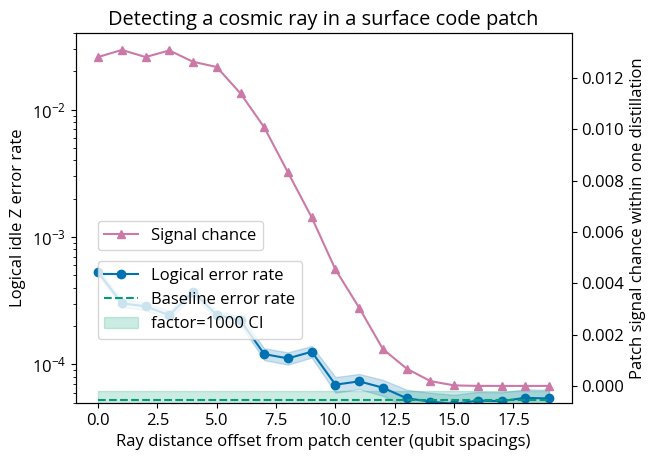

In [13]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
ax.plot(distances, [f.best for f in result_fits], 'o-', color='C0', label='Logical error rate')
ax.fill_between(distances, [f.low for f in result_fits], [f.high for f in result_fits], color='C0', alpha = 0.2)
 
ax.plot(distances, baseline_fit.best*np.ones(len(distances)), '--', color='C2', label='Baseline error rate')
ax.fill_between(distances, baseline_fit.low, baseline_fit.high, color='C2', alpha = 0.2, label='factor=1000 CI')
ax.set_ylabel('Logical idle Z error rate')
ax.set_yscale('log')
ax.set_ylim(5e-5, 4e-2)
ax.set_xlabel('Ray distance offset from patch center (qubit spacings)')

# TODO: not showing up in legend
ax1.plot(distances, signal_chances, '^-', color='C1', label='Signal chance')
ax1.set_ylabel('Patch signal chance within one distillation')

ax.legend(loc='lower left', bbox_to_anchor=(0.028, 0.15))
ax1.legend(loc='lower left', bbox_to_anchor=(0.028, 0.39))

plt.title('Detecting a cosmic ray in a surface code patch')

# plt.savefig('exterior_detection.png', bbox_inches='tight', dpi=300)
plt.savefig('../figures/exterior_detection.svg', bbox_inches='tight')
plt.show()

In [57]:
signal_chances

array([mpf('1.0'), mpf('1.0'), mpf('1.0'), mpf('1.0'), mpf('1.0'),
       mpf('1.0'), mpf('1.0'), mpf('1.0'), mpf('1.0'), mpf('1.0'),
       mpf('1.0'), mpf('1.0'),
       mpf('0.99999999999999999999999999999999999999999998211487688'),
       mpf('0.99999999990923890507818746170489039357112070111686756'),
       mpf('0.87100814064910141374988392629300628254299935164734633'),
       mpf('0.22556972633796637988130612992178655689144095499750202'),
       mpf('0.00011425021792554342130194582162567447451829512888133972'),
       mpf('0.00000052411404332844722937065973717673374705268071109045458'),
       mpf('0.00000000010780213527116393830058466350297301636055512902728357'),
       mpf('0.000000000096814043645580263638539039034967896236934402843597174')],
      dtype=object)

In [11]:
patch_fpr_per_cycle = 1-(1-spec.baseline_signal_rate)**len(sim._windows)
patch_fpr_per_cycle

2.478288685381358e-10

In [12]:
patch_fpr_per_second = patch_fpr_per_cycle/patch.patch.cycle_time()
patch_fpr_per_second

0.000264774432198863